In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv("Payments.csv")

# Create a graph
G = nx.Graph()

# Add nodes to the graph
nodes = set(data["Sender"]).union(set(data["Receiver"]))
G.add_nodes_from(nodes)

# Calculate edge weights
edge_weights = {}
for sender, receiver, amount in zip(data["Sender"], data["Receiver"], data["Amount"]):
    key = (sender, receiver)
    if key not in edge_weights:
        edge_weights[key] = []
    edge_weights[key].append(amount)

# Add edges to the graph with weights
for (sender, receiver), amounts in edge_weights.items():
    total_amount = sum(amounts)
    normalized_weight = total_amount / len(amounts)
    G.add_edge(sender, receiver, weight=normalized_weight)

# Re-index the nodes to ensure contiguous indices starting from 0
mapping = {node: idx for idx, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)

# Convert the networkx graph to a PyTorch Geometric Data object
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(list(nx.get_edge_attributes(G, 'weight').values()), dtype=torch.float)
x = torch.eye(len(G.nodes()), dtype=torch.float)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

# Create an instance of the GCN model
input_dim = data.num_features
hidden_dim = 64
output_dim = 32
model = GCN(input_dim, hidden_dim, output_dim)

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, torch.zeros_like(out))
    loss.backward()
    optimizer.step()

# Get the node embeddings
model.eval()
with torch.no_grad():
    node_embeddings = model(data).numpy()

# Scale the node embeddings
scaler = StandardScaler()
node_embeddings_scaled = scaler.fit_transform(node_embeddings)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of the variance
node_embeddings_pca = pca.fit_transform(node_embeddings_scaled)

# Apply K-means clustering on the PCA-reduced embeddings
k = 2  # Number of clusters
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(node_embeddings_pca)

# Apply Local Outlier Factor (LOF) for anomaly detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_scores = lof.fit_predict(node_embeddings_pca)

# Identify outliers
outliers = np.where(outlier_scores == -1)[0]

# Print the potentially fraudulent transactions
print("Potentially Fraudulent Transactions:")
for outlier in outliers:
    print(f"Node: {list(mapping.keys())[list(mapping.values()).index(outlier)]}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Potentially Fraudulent Transactions:
Node: 2050
Node: 2054
Node: 2057
Node: 2066
Node: 2071
Node: 2072
Node: 2073
Node: 2075
Node: 2076
Node: 2080
Node: 2081
Node: 2085
Node: 2088
Node: 2089
Node: 2090
Node: 2097
Node: 2100
Node: 2104
Node: 2107
Node: 2108
Node: 2109
Node: 2111
Node: 2124
Node: 1008
Node: 1029
Node: 1032
Node: 1039
Node: 1051
Node: 1058
Node: 1070
Node: 1073
Node: 1078
Node: 1080
Node: 1103
Node: 1111
Node: 1114
Node: 1128
Node: 1168
Node: 1190
Node: 1205
Node: 1212
Node: 1262
Node: 1289
Node: 1292
Node: 1313
Node: 1318
Node: 1348
Node: 1374
Node: 1376
Node: 1395
Node: 1398
Node: 1421
Node: 1441
Node: 1444
Node: 1451
Node: 1515
Node: 1549
Node: 1574
Node: 1576
Node: 1634
Node: 1671
Node: 1777
Node: 1970
Node: 1971
Node: 1977
Node: 1978
Node: 1990
Node: 1991
Node: 1998
Node: 2001
Node: 2003
Node: 2014
Node: 2023
Node: 2025
Node: 2026
Node: 2027
Node: 2031
Node: 2036
Node: 2039
Node: 2047


In [ ]:
# Evaluate the clustering results
if len(np.unique(kmeans.labels_)) > 1:
    silhouette = silhouette_score(node_embeddings_pca, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(node_embeddings_pca, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(node_embeddings_pca, kmeans.labels_)

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
else:
    print("Clustering resulted in only one cluster. Evaluation metrics cannot be calculated.")

Silhouette Score: 0.93
Davies-Bouldin Index: 0.09
Calinski-Harabasz Index: 163.97


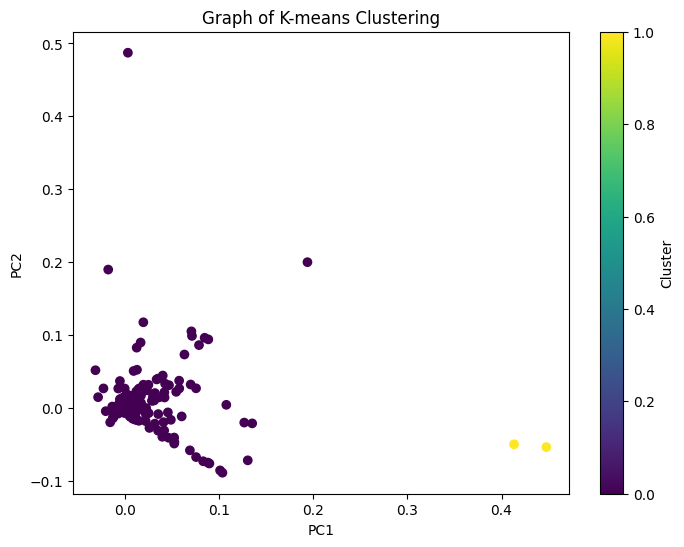

In [ ]:
pca = PCA(n_components=2)  # Reduce to 2-dimensional space for visualization
reduced_embeddings = pca.fit_transform(node_embeddings)

# Plot the PCA graph of k-means clustering
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Graph of K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()